# Preliminaries: EDA; ARMA and ARIMA models

Notation:

- TS: time series

## Setup

In [4]:
import matplotlib.pyplot as plt
import sys
import pandas as pd
from pathlib import Path

In [10]:
from pathlib import Path

IMAGES_PATH = Path() / "images"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

### Download the data

Let's download the ridership data from the ageron/data project. It originally comes from Chicago's Transit Authority, and was downloaded from the [Chicago's Data Portal](https://homl.info/ridership).

In [6]:
!wget https://github.com/ageron/data/raw/main/ridership.tgz
!mkdir data
!mv ridership.tgz data
!tar -xvzf data/ridership.tgz --directory=data/

--2025-03-13 17:24:18--  https://github.com/ageron/data/raw/main/ridership.tgz
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ageron/data/main/ridership.tgz [following]
--2025-03-13 17:24:18--  https://raw.githubusercontent.com/ageron/data/main/ridership.tgz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108512 (106K) [application/octet-stream]
Saving to: ‘ridership.tgz’

ridership.tgz       100%[===================>] 105.97K  --.-KB/s    in 0.07s   

2025-03-13 17:24:19 (1.43 MB/s) - ‘ridership.tgz’ saved [108512/108512]

mkdir: data: File exists
x ridership/
x ridership/CTA_-_Ridership_-_Dai

In [7]:
# read data
path = Path("data/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])

# some cleaning
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

In [8]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


On January 1st, 2001, 297,192 people boarded a bus in Chicago, and 126,455 boarded
a train. The `day_type` column contains `W` for Weekdays, `A` for Saturdays, and `U` for
Sundays or holidays.

## EDA

Notice the dramatic impact that the COVID pandemic had

Text(0.5, 0.98, 'Chicago Ridership Time Series')

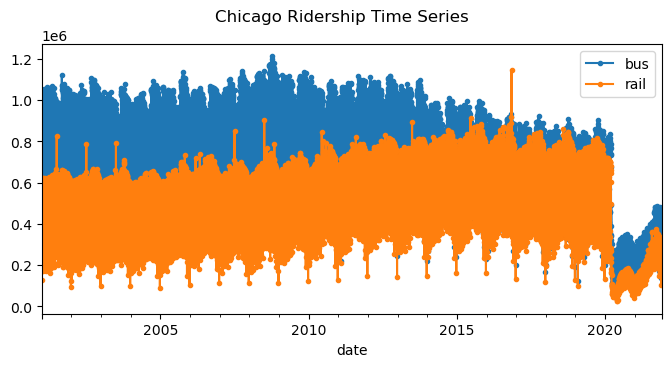

In [43]:
df.plot(marker=".", figsize=(8, 3.5))
plt.suptitle("Chicago Ridership Time Series")

Let's look at the first few months of 2019 (note that Pandas treats the range boundaries as inclusive):

Text(0.5, 0.98, 'Chicago Ridership Time Series')

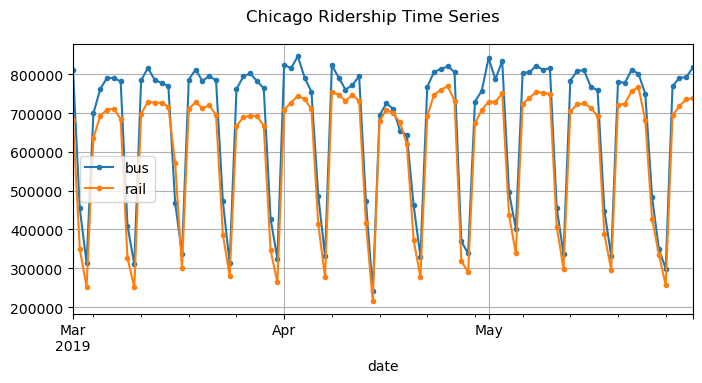

In [16]:
df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.suptitle("Chicago Ridership Time Series")

### Naive forecasting

Let's begin with naive forecasts, overlaying the two time series (for bus and rail) as
well as the same time series lagged by one week (i.e., shifted toward the right) using
dotted lines. 

We’ll also plot the difference `diff_7` between the two (i.e., the value at time t
minus the value at time t – 7) (*differencing*).

Text(0.5, 1.0, '7-Day Difference')

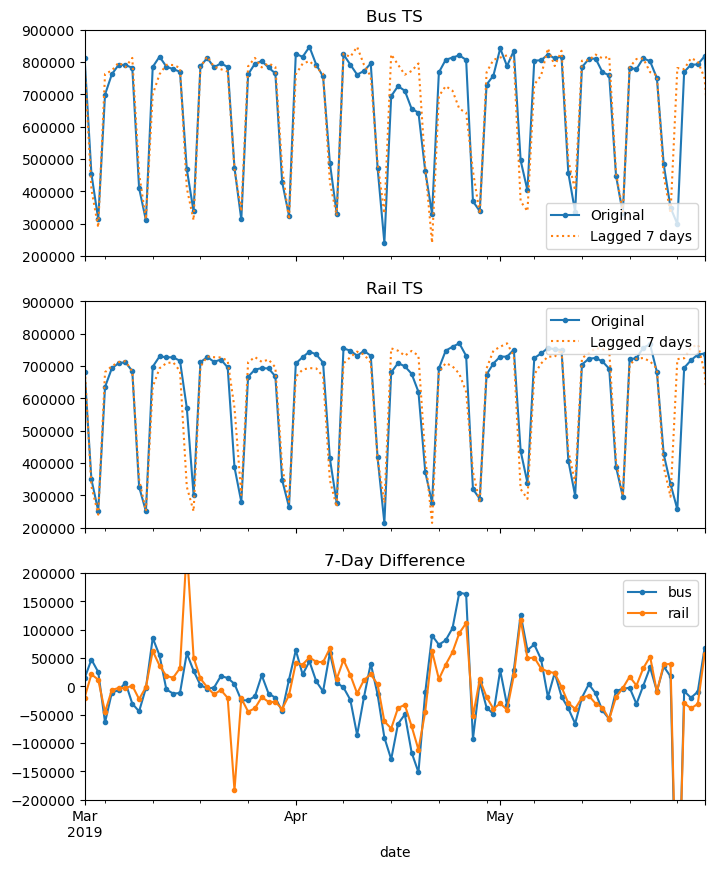

In [42]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 10))
#df.plot(ax=axs[0], legend=False, marker=".")  # original time series
#df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # lagged

df['bus'].plot(ax=axs[0], marker=".", label='Original')  
df['bus'].shift(7).plot(ax=axs[0], linestyle=":", label='Lagged 7 days')  
axs[0].set_ylim([2e5, 9e5]) 
axs[0].legend(loc="lower right")

df['rail'].plot(ax=axs[1], marker=".", label='Original')  
df['rail'].shift(7).plot(ax=axs[1], linestyle=":", label='Lagged 7 days')  
axs[1].set_ylim([2e5, 9e5]) 
axs[1].legend(loc="upper right")

diff_7.plot(ax=axs[2], marker=".")  # 7-day difference time series
axs[2].set_ylim([-2e5, 2e5]) 

axs[0].set_title("Bus TS")
axs[1].set_title("Rail TS")
axs[2].set_title("7-Day Difference")

👆Time series overlaid with 7-day lagged time series (top), and difference between t and t – 7 (bottom)

Not too bad! Notice how closely the lagged time series track the actual time series.
When a time series is correlated with a lagged version of itself, we say that the time
series is autocorrelated. As you can see, most of the differences are fairly small, except
at the end of May (Memorial Day weekend as checked below). 

In [11]:
list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

Mean absolute error (MAE), also called mean absolute deviation (MAD):

In [12]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

Mean absolute percentage error (MAPE):

In [13]:
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

Now let's look at the yearly seasonality and the long-term trends:

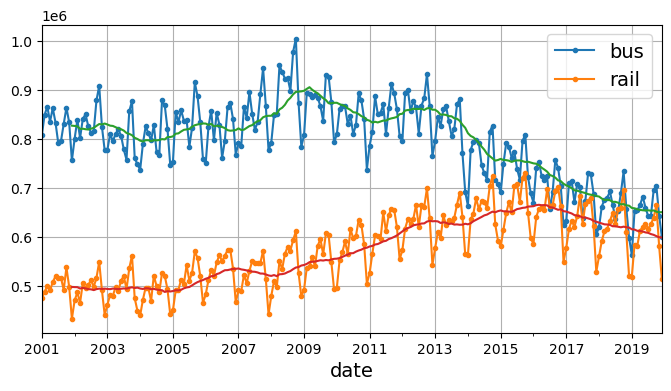

In [14]:
period = slice("2001", "2019")
# had to include a clause to restrict the operation only to numeric columns
df_monthly = df.select_dtypes(include='number').resample('ME').mean()  # compute the mean for each month
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()

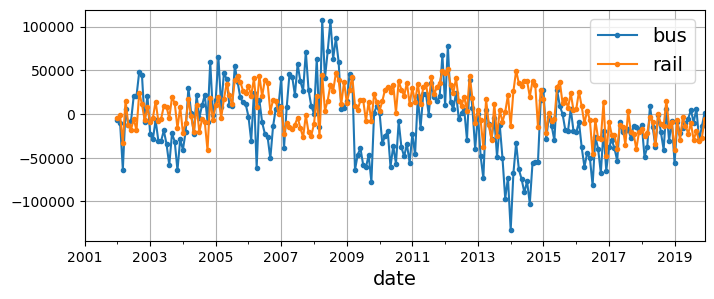

In [15]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
plt.show()

## Basic forecasting with (S)AR(I)MA

If running on Colab or Kaggle, install the statsmodels library:

In [16]:
if "google.colab" in sys.modules:
    %pip install -q -U statsmodels

### SARIMA

#### Basics of SARIMA

Specifies the time window

In [17]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")

Seasonal ARIMA (SARIMA) model: models the time series in the same way as ARIMA, but it additionally models
a seasonal component for a given frequency (e.g., weekly), using the exact same
ARIMA approach. 

It has a total of seven hyperparameters: 

- $p$ and $q$ from ARMA: how far back in the autoregressive and moving average terms
- $d$ from ARIMA: how many rounds of differencing
- $P$, $D$, and $Q$ seasonal pattern
- $s$: period

Below, 

- `order=(1, 0, 0)` means that `p = 1, d = 0, q = 0` (no differencing, no moving average term)
- `seasonal_order=(0, 1, 1, 7)` means that `P = 0, D = 1, Q = 1`, and `s = 7` (period = 7 days)

In [18]:
model = ARIMA(rail_series,
              order=(1, 0, 0),
              seasonal_order=(0, 1, 1, 7))

#### Fit

We fit the model and make a forecast for tomorrow.

In [19]:
model = model.fit()
y_pred = model.forecast()  # returns 427,758.6

In [20]:
y_pred.iloc[0]  # ARIMA forecast

427758.6262864085

Ground truth

In [21]:
df["rail"].loc["2019-06-01"]  # target value

379044

In [22]:
df["rail"].loc["2019-05-25"]  # naive forecast (value from one week earlier)

426932

MAE

In [23]:
abs(y_pred.iloc[0]-df["rail"].loc["2019-06-01"])

48714.626286408515

To check the accuracy of the model, we run the same code in a loop to make forecasts for every day in March,
April, and May, and compute the MAE over that period

In [24]:
from tqdm import tqdm

In [25]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")

y_preds = []
for today in tqdm(time_period.shift(-1)):
    model = ARIMA(rail_series[origin:today],  # train on data up to "today"
                  order=(1, 0, 0),
                  seasonal_order=(0, 1, 1, 7))
    model = model.fit()  # note that we retrain the model every day!
    y_pred = model.forecast().iloc[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()  # returns 32,040.7

100%|███████████████████████████████████████████| 92/92 [00:33<00:00,  2.77it/s]


In [26]:
mae

32040.720091784442

Displays the SARIMA forecasts

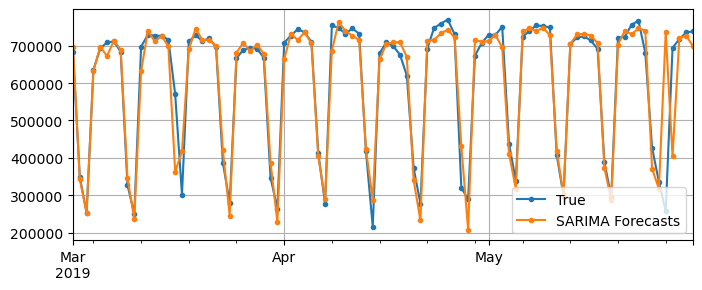

In [36]:
fig, ax = plt.subplots(figsize=(8, 3))
rail_series.loc[time_period].plot(label="True", ax=ax, marker=".", grid=True)
ax.plot(y_preds, marker=".", label="SARIMA Forecasts")
plt.legend(fontsize=10, loc='lower right')
plt.show()

### ARMA

ARMA models are simpler and do not handle explicit seasonality like SARIMA does. **ARMA** models only consider non-seasonal autoregressive (AR) and moving average (MA) components, so there is no `seasonal_order` parameter. These models assume the series is stationary and do not explicitly model seasonality.

To fit an **ARMA** model in `statsmodels`, you can use the same `ARIMA` class but omit the `seasonal_order` argument. 

In [30]:
y_preds_ARMA = []
for today in tqdm(time_period.shift(-1)):
    # Define the ARMA model (ARIMA with no seasonal components and differencing=0)
    model_ARMA = ARIMA(rail_series[origin:today],  # train on data up to "today"
                  order=(1, 0, 1))
                  #seasonal_order=(0, 1, 1, 7))
    model_ARMA = model_ARMA.fit()  # note that we retrain the model every day!
    y_pred = model_ARMA.forecast().iloc[0]
    y_preds_ARMA.append(y_pred)

y_preds_ARMA = pd.Series(y_preds_ARMA, index=time_period)
mae_ARMA = (y_preds_ARMA - rail_series[time_period]).abs().mean()  # returns 32,040.7

100%|███████████████████████████████████████████| 92/92 [00:01<00:00, 82.99it/s]


In [32]:
mae_ARMA

132929.48661171878

Displays the ARMA forecasts

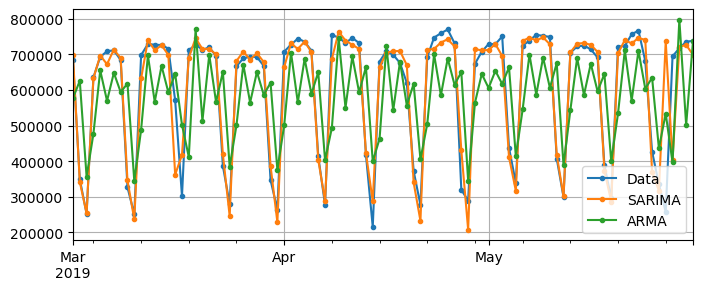

In [37]:
fig, ax = plt.subplots(figsize=(8, 3))
rail_series.loc[time_period].plot(label="Data", ax=ax, marker=".", grid=True)
ax.plot(y_preds, marker=".", label="SARIMA")
ax.plot(y_preds_ARMA, marker=".", label="ARMA")
plt.legend(fontsize=10, loc='lower right')
plt.show()

In [38]:
print(model_ARMA.summary())

                               SARIMAX Results                                
Dep. Variable:                   rail   No. Observations:                  150
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2010.275
Date:                Fri, 10 Jan 2025   AIC                           4028.550
Time:                        18:01:07   BIC                           4040.592
Sample:                    01-01-2019   HQIC                          4033.442
                         - 05-30-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        5.82e+05   2.47e+04     23.558      0.000    5.34e+05     6.3e+05
ar.L1         -0.1132      0.161     -0.704      0.482      -0.428       0.202
ma.L1          0.7718      0.090      8.600      0.0

### ARIMA

The process is very similar to SARIMA but without explicitly modeling seasonality (i.e., no `seasonal_order` parameter). An **ARIMA** model assumes there is no seasonality, and it focuses on the non-seasonal components: **AR (autoregression)**, **I (differencing to remove trends)**, and **MA (moving average)**.

Specify the `order=(p, d, q)` parameters based on your analysis or experimentation.

In [39]:
y_preds_ARIMA = []
for today in tqdm(time_period.shift(-1)):
    model_ARIMA = ARIMA(rail_series[origin:today],  # train on data up to "today"
                  order=(1, 1, 1))
    model_ARIMA = model_ARIMA.fit()  # note that we retrain the model every day!
    y_pred = model_ARIMA.forecast().iloc[0]
    y_preds_ARIMA.append(y_pred)

y_preds_ARIMA = pd.Series(y_preds_ARIMA, index=time_period)
mae_ARIMA = (y_preds_ARIMA - rail_series[time_period]).abs().mean()  

100%|███████████████████████████████████████████| 92/92 [00:01<00:00, 53.27it/s]


In [40]:
mae_ARIMA

135757.1900666448

Displays the ARIMA forecasts

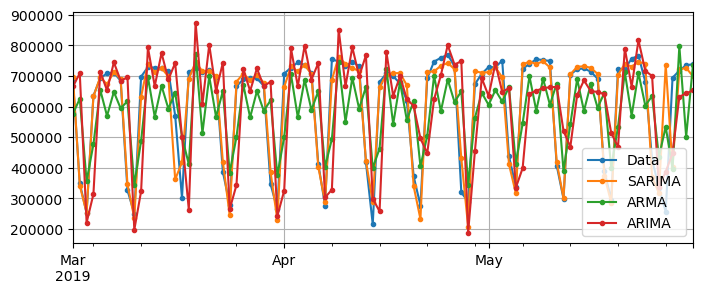

In [41]:
fig, ax = plt.subplots(figsize=(8, 3))
rail_series.loc[time_period].plot(label="Data", ax=ax, marker=".", grid=True)
ax.plot(y_preds, marker=".", label="SARIMA")
ax.plot(y_preds_ARMA, marker=".", label="ARMA")
ax.plot(y_preds_ARIMA, marker=".", label="ARIMA")
plt.legend(fontsize=10, loc='lower right')
plt.show()

## Autocorrelation function

How to plot the Autocorrelation Function (ACF) and the partial Autocorrelation Function (PACF)

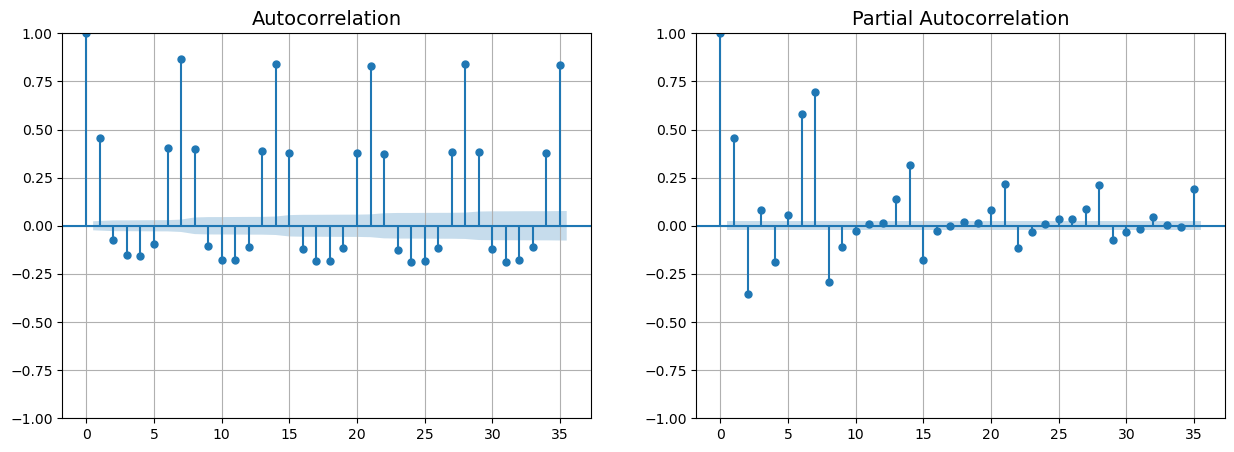

In [48]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(df[period]["rail"], ax=axs[0], lags=35)
axs[0].grid()
plot_pacf(df[period]["rail"], ax=axs[1], lags=35, method="ywm")
axs[1].grid()
plt.show()